# 여행 만족도 EDA (Seaborn 활용)

이 노트북은 `travel_insight_v1.csv` 데이터를 간단하게 살펴보고, 피처와 만족도 레이블 간 관계를 Seaborn 그래프입니다.

In [38]:
import pandas as pd
import numpy as np
import asyncio
if hasattr(asyncio, "WindowsSelectorEventLoopPolicy"):
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

import seaborn as sns
import matplotlib.pyplot as plt

# 보기 쉬운 기본 스타일을 설정
sns.set_theme(style="whitegrid", palette="crest")
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정 (윈도우 기본)
plt.rcParams['axes.unicode_minus'] = False

In [39]:
# 1) CSV 파일을 불러오고 기본 크기를 확인
file_path = "../../data/training/final/travel_insight_v1.csv"
travel = pd.read_csv(file_path)
print(f"데이터 행(row) 수: {len(travel)}")
print(f"데이터 열(column) 수: {len(travel.columns)}")
travel.head()

데이터 행(row) 수: 2560
데이터 열(column) 수: 31


,TRAVEL_ID,AGE_GRP,GENDER,MOVE_CNT,MVMN_NM,INCOME,HOUSE_INCOME,LODGING_PAYMENT_SUM,TRIP_DAYS,DGSTFN_AVG,...,ACTIVITY_HISTORY_ROWS,ACTIVITY_PAYMENT_SUM,ACTIVITY_TYPE_UNIQUE,MISSION_CODE_COUNT,TRAVEL_COMPANIONS_NUM,TRAVEL_STATUS_ACCOMPANY,IS_FAILED_TRIP,TRAIN_PURPOSE,TRAVEL_MISSION_CHECK,MISSION_PURPOSE_GAP_RATIO
0,e_e000004,40,남,3,UNKNOWN,7,8.0,0,1,4.00,...,3,0,2,3,2,자녀 동반 여행,1,3,11;3;4,0.6667
1,e_e000006,30,남,8,UNKNOWN,5,7.0,0,2,4.75,...,11,58500,6,3,1,2인 가족 여행,0,21,10;21;27,0.6667
2,e_e000009,30,여,10,UNKNOWN,4,12.0,0,2,4.50,...,15,319340,5,3,1,2인 여행(가족 외),0,2;4,1;22;7,1.0000
3,e_e000010,30,여,12,UNKNOWN,4,4.0,0,2,4.25,...,18,421160,5,3,0,나홀로 여행,1,3;6,1;3;6,0.3333
4,e_e000011,60,여,10,UNKNOWN,7,7.0,0,3,3.90,...,16,764300,6,3,3,3인 이상 여행(가족 외),0,1;21,2;24;6,1.0000


## 1. 연령대별 평균 만족도 (DGSTFN_AVG)
연령대(AGE_GRP)에 따라 만족도 평균이 어떻게 달라지는지 막대그래프로 비교해 봅니다.

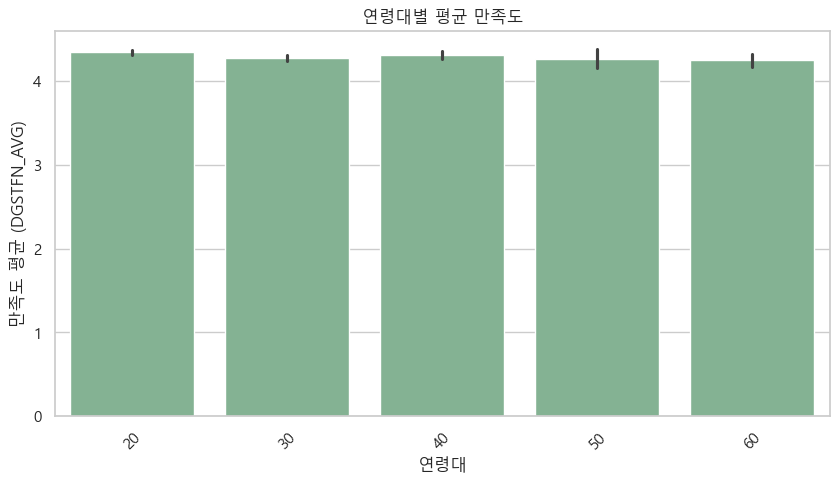

In [3]:
plt.figure(figsize=(10, 5))
age_order = sorted(travel["AGE_GRP"].dropna().unique())
sns.barplot(data=travel, x="AGE_GRP", y="DGSTFN_AVG", order=age_order, errorbar=("ci", 95))
plt.title("연령대별 평균 만족도")
plt.xlabel("연령대")
plt.ylabel("만족도 평균 (DGSTFN_AVG)")
plt.xticks(rotation=45)
plt.show()

## 2. 여행 동행 인원에 따른 실패 확률 (IS_FAILED_TRIP)
동행 인원(TRAVEL_COMPANIONS_NUM)이 늘어나면서 여행 실패 비율이 어떻게 변하는지 살펴봅니다.

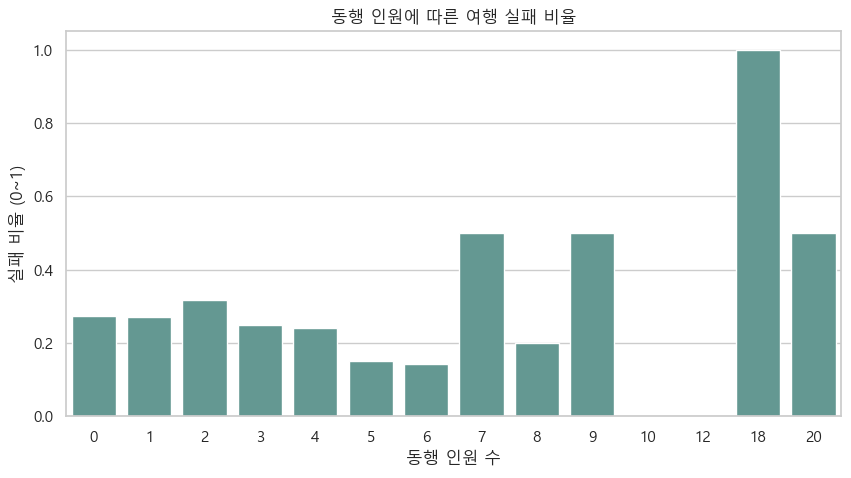

In [4]:
failed_rate = (travel.groupby("TRAVEL_COMPANIONS_NUM", dropna=False)["IS_FAILED_TRIP"].mean().reset_index())
failed_rate.rename(columns={"IS_FAILED_TRIP": "FAILED_RATE"}, inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(data=failed_rate, x="TRAVEL_COMPANIONS_NUM", y="FAILED_RATE", color="#5BA199")
plt.title("동행 인원에 따른 여행 실패 비율")
plt.xlabel("동행 인원 수")
plt.ylabel("실패 비율 (0~1)")
plt.show()

## 3. 여행 기간과 만족도 관계 (TRIP_DAYS vs DGSTFN_AVG)
여행 기간(TRIP_DAYS)이 길수록 만족도(DGSTFN_AVG)가 높아지는지 산점도와 추세선을 함께 봅니다.

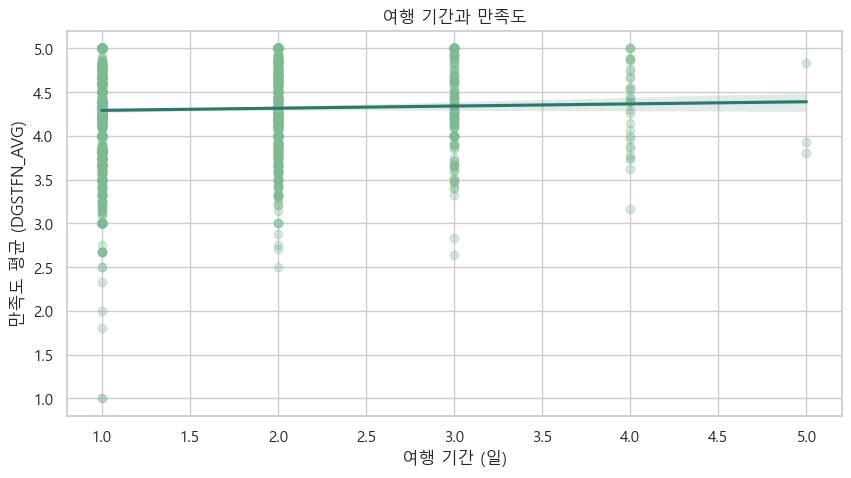

In [5]:
plt.figure(figsize=(10, 5))
sns.regplot(data=travel, x="TRIP_DAYS", y="DGSTFN_AVG", scatter_kws={"alpha": 0.3}, line_kws={"color": "#2C786C"})
plt.title("여행 기간과 만족도")
plt.xlabel("여행 기간 (일)")
plt.ylabel("만족도 평균 (DGSTFN_AVG)")
plt.show()

## 4. 주요 수치형 피처와 만족도 지표 상관관계
주요 수치형 피처와 만족도/충성도 지표 간의 상관관계를 히트맵으로 요약합니다. 값이 1에 가까울수록 양의 상관이, -1에 가까울수록 음의 상관이 있습니다.

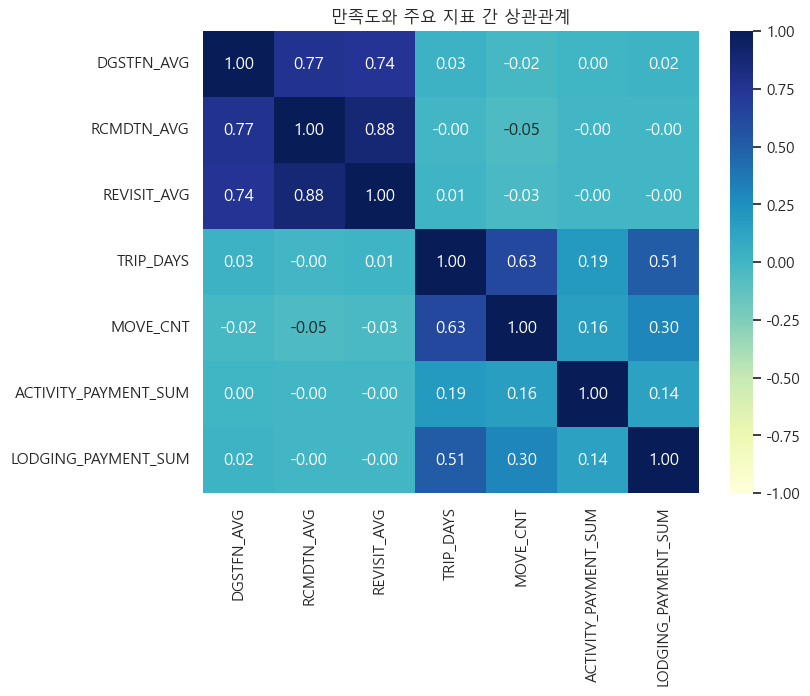

In [8]:
numeric_cols = ["DGSTFN_AVG", "RCMDTN_AVG", "REVISIT_AVG", "TRIP_DAYS", "MOVE_CNT",
                 "ACTIVITY_PAYMENT_SUM", "LODGING_PAYMENT_SUM"]
heatmap_data = travel[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", vmin=-1, vmax=1)
plt.title("만족도와 주요 지표 간 상관관계")
plt.show()

## 5. DataFrame으로 복합 피처 만들기
기존 컬럼을 조합해 새로운 정보를 담은 피처를 만들어 두면 다양한 시각화를 빠르게 시도할 수 있습니다. 1일 평균 지출, 하루 이동 횟수, 만족도 차이 등 기본적인 조합 피처를 만들어 봅니다.

In [9]:
# 복합 피처 생성
travel = travel.copy()
travel["TOTAL_PAYMENT_SUM"] = travel["ACTIVITY_PAYMENT_SUM"].fillna(0) + travel["LODGING_PAYMENT_SUM"].fillna(0)
travel["SPEND_PER_DAY"] = travel["TOTAL_PAYMENT_SUM"] / travel["TRIP_DAYS"].replace(0, pd.NA)
travel["MOVE_PER_DAY"] = travel["MOVE_CNT"] / travel["TRIP_DAYS"].replace(0, pd.NA)
travel["SATISFACTION_GAP"] = travel["DGSTFN_AVG"] - travel["RCMDTN_AVG"]
travel["FAILED_LABEL"] = travel["IS_FAILED_TRIP"].map({0: "성공", 1: "실패"})
travel[["TOTAL_PAYMENT_SUM", "SPEND_PER_DAY", "MOVE_PER_DAY", "SATISFACTION_GAP", "FAILED_LABEL"]].head()

,TOTAL_PAYMENT_SUM,SPEND_PER_DAY,MOVE_PER_DAY,SATISFACTION_GAP,FAILED_LABEL
0,0,0.000000,3.000000,0.33,실패
1,58500,29250.000000,4.000000,0.00,성공
2,319340,159670.000000,5.000000,0.00,성공
3,421160,210580.000000,6.000000,0.33,실패
4,764300,254766.666667,3.333333,0.10,성공


## 6. 만족도-추천 격차를 한눈에 보기
히스토그램 대신 박스플롯과 점 그래프를 곿치면 중간값과 분포 폭이 바로 보입니다.
또한 하루 평균 지출(`SPEND_PER_DAY`)과 여행 일수(`TRIP_DAYS`)를 함께 표시해 복합적인 관계를 살팔봎니다.

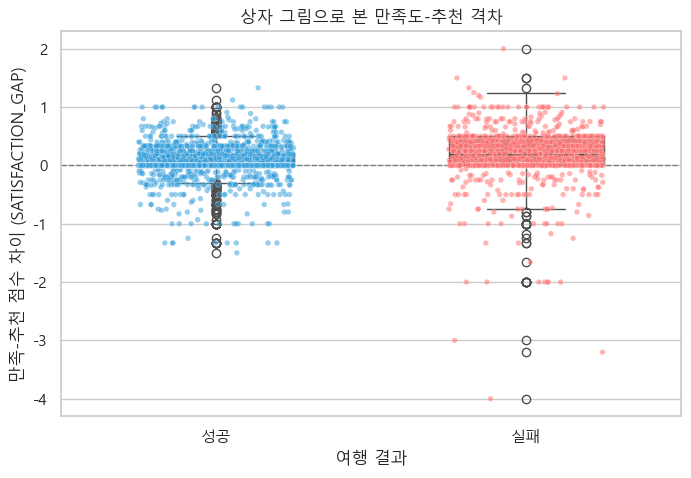

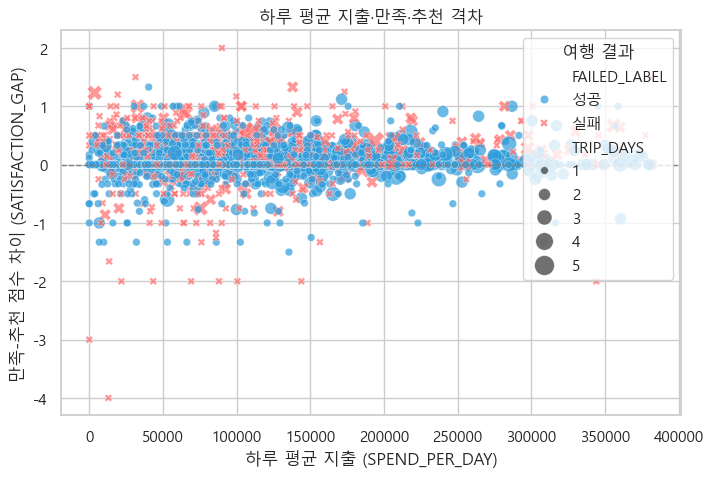

In [10]:
# ----------------------------------------------------
# 1. Boxplot + Stripplot
# ----------------------------------------------------
gap_data = travel.dropna(subset=["SATISFACTION_GAP", "FAILED_LABEL"]).copy()

palette_map = {"성공": "#2D9CDB", "실패": "#FF6B6B"}
category_order = ["성공", "실패"]

plt.figure(figsize=(8, 5))

# Boxplot: hue 인자를 추가하여 경고 해결
sns.boxplot(
    data=gap_data,
    x="FAILED_LABEL",
    y="SATISFACTION_GAP",
    order=category_order,
    palette=palette_map,
    hue="FAILED_LABEL",  # x축 변수를 hue에도 지정
    legend=False,        # 범례는 불필요하므로 비활성화
    width=0.5
)

# Stripplot: hue 인자를 추가하여 경고 해결
sns.stripplot(
    data=gap_data,
    x="FAILED_LABEL",
    y="SATISFACTION_GAP",
    order=category_order,
    palette=palette_map,
    hue="FAILED_LABEL",  # x축 변수를 hue에도 지정
    legend=False,        # 범례는 불필요하므로 비활성화
    jitter=0.25,
    alpha=0.5,
    size=4,
    edgecolor="white",
    linewidth=0.3
)

plt.title("상자 그림으로 본 만족도-추천 격차")
plt.xlabel("여행 결과")
plt.ylabel("만족-추천 점수 차이 (SATISFACTION_GAP)")
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.show()

# ----------------------------------------------------
# 2. Scatterplot
# ----------------------------------------------------
scatter_data = gap_data.dropna(subset=["SPEND_PER_DAY", "TRIP_DAYS"]).copy()
upper_limit = scatter_data["SPEND_PER_DAY"].quantile(0.97)
scatter_data = scatter_data[scatter_data["SPEND_PER_DAY"] <= upper_limit]

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=scatter_data,
    x="SPEND_PER_DAY",
    y="SATISFACTION_GAP",
    hue="FAILED_LABEL",
    style="FAILED_LABEL",
    hue_order=category_order,
    style_order=category_order,
    palette=palette_map,
    markers={"성공": "o", "실패": "X"},
    size="TRIP_DAYS",
    sizes=(30, 200),
    alpha=0.7,
    edgecolor="white",
    linewidth=0.3
)

plt.title("하루 평균 지출·만족·추천 격차")
plt.xlabel("하루 평균 지출 (SPEND_PER_DAY)")
plt.ylabel("만족-추천 점수 차이 (SATISFACTION_GAP)")
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.legend(title="여행 결과", loc="upper right")
plt.show()

## 7. 하루 이동량 대비 만족도
이동 횟수를 여행 기간으로 나눈 `MOVE_PER_DAY` 지표와 만족도 평균(DGSTFN_AVG)의 관계를 산점도로 확인합니다. 추세선을 함께 표시해 전체 경향을 파악합니다.

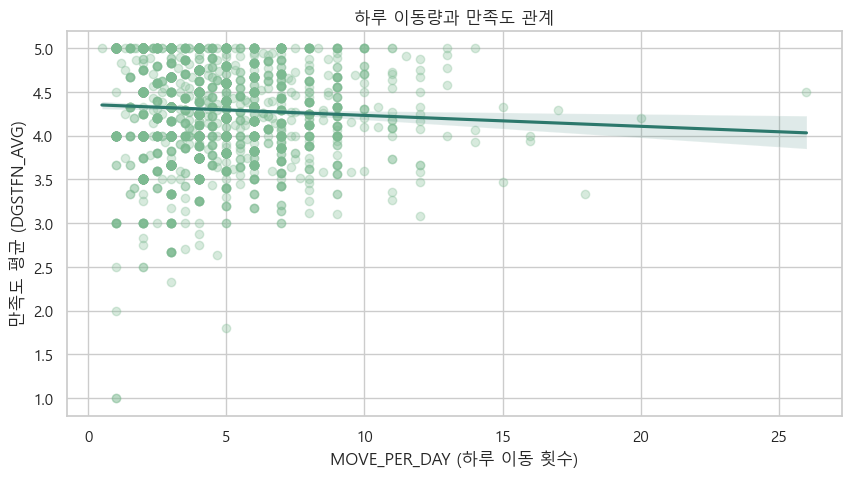

In [11]:
plt.figure(figsize=(10, 5))
move_data = travel.dropna(subset=["MOVE_PER_DAY", "DGSTFN_AVG"])
sns.regplot(data=move_data, x="MOVE_PER_DAY", y="DGSTFN_AVG", scatter_kws={"alpha": 0.3}, line_kws={"color": "#2C786C"})
plt.title("하루 이동량과 만족도 관계")
plt.xlabel("MOVE_PER_DAY (하루 이동 횟수)")
plt.ylabel("만족도 평균 (DGSTFN_AVG)")
plt.show()

## 8. 미션 일치도 구간별 실패 비율
`MISSION_PURPOSE_GAP_RATIO`를 분위수로 나눠 미션 일치도가 낮은 그룹일수록 실패 비율이 높은지 살펴봅니다. `pd.qcut`을 활용해 네 개 구간으로 나눕니다.

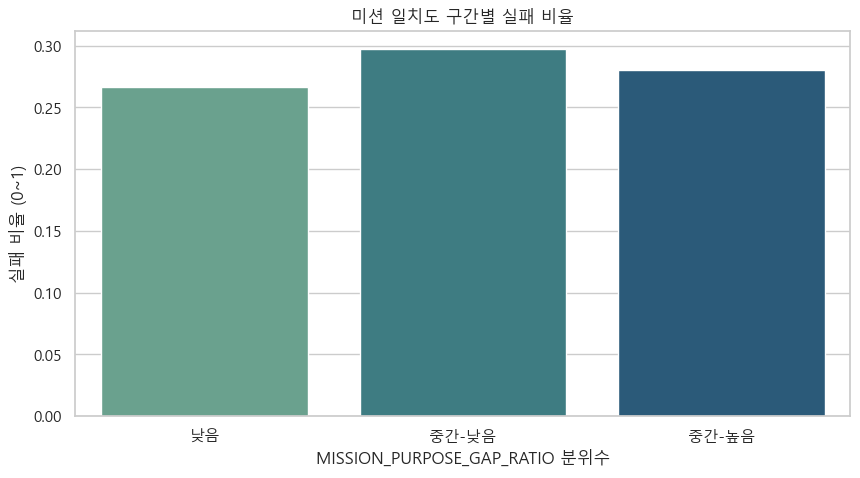

In [37]:
mission_data = travel.dropna(subset=["MISSION_PURPOSE_GAP_RATIO"]).copy()
mission_gap = pd.qcut(
    mission_data["MISSION_PURPOSE_GAP_RATIO"],
    q=4,
    duplicates="drop"
)
labels_full = ["낮음", "중간-낮음", "중간-높음", "높음"]
label_count = len(mission_gap.cat.categories)
mission_data["MISSION_GAP_GROUP"] = mission_gap.cat.rename_categories(labels_full[:label_count])

mission_rate = (
    mission_data.groupby("MISSION_GAP_GROUP", observed=True)["IS_FAILED_TRIP"]
    .mean()
    .reset_index()
)
mission_rate.rename(columns={"IS_FAILED_TRIP": "FAILED_RATE"}, inplace=True)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=mission_rate,
    x="MISSION_GAP_GROUP",
    y="FAILED_RATE",
    hue="MISSION_GAP_GROUP",
    dodge=False,
    palette="crest"
)
if ax.legend_:
    ax.legend_.remove()
plt.title("미션 일치도 구간별 실패 비율")
plt.xlabel("MISSION_PURPOSE_GAP_RATIO 분위수")
plt.ylabel("실패 비율 (0~1)")
plt.show()
